In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pertpy as pt
import warnings
from matplotlib import rcParams
from gprofiler import GProfiler
from tqdm import tqdm
import torch
from pathlib import Path 

FIGSIZE=(3,3)
rcParams['figure.figsize']=FIGSIZE

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

**Util functions**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

def plot_umap_with_compound_and_batch(adata, compound_category='compound', batch_category='batch', target_compound='UNTREATED', dim_red="umap"):
    """
    Plot UMAP with points colored based on compound category and batch.
    
    Parameters:
        adata (Anndata): Annotated data object containing precomputed UMAP coordinates.
        compound_category (str): Name of the compound category column in adata.obs.
        batch_category (str): Name of the batch category column in adata.obs.
        target_compound (str): Compound to highlight, others will be grey.
    """
    # Create color palette based on unique combinations of compound and batch
    unique_combinations = adata.obs[[compound_category, batch_category]].drop_duplicates()
    palette = sns.color_palette("colorblind", n_colors=len(unique_combinations))
    colors = dict(zip(unique_combinations.apply(tuple, axis=1), palette))

    # Plot all points in grey
    np.random.seed(13)
    plt.scatter(adata.obsm[f'X_{dim_red}'][:, 0], adata.obsm[f'X_{dim_red}'][:, 1], color='grey', alpha=0.5, label='Other', s=2)
    
    # Plot points colored by compound and batch
    for idx, (compound, batch) in enumerate(unique_combinations.values):
        indices = (adata.obs[compound_category] == compound) & (adata.obs[batch_category] == batch)
        if compound == target_compound:
            plt.scatter(adata.obsm[f'X_{dim_red}'][indices, 0], adata.obsm[f'X_{dim_red}'][indices, 1], 
                        color=colors[(compound, batch)], label=f'{compound}_{batch}')

    
    plt.title(f'UMAP colored by {compound_category} and {batch_category}')
    plt.xlabel(f'{dim_red} 1')
    plt.ylabel(f'{dim_red} 2')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

def differentially_enriched_paths(clus1, clus2):
    clus1 = clus1.set_index("name")
    clus2 = clus2.set_index("name")
    intersected = np.intersect1d(clus1.index, clus2.index)
    diff = np.setdiff1d(clus1.index, clus2.index)
    clus1_intersected = clus1.loc[intersected]
    clus2_intersected = clus2.loc[intersected]
    return -np.log10(clus1_intersected["p_value"]/clus2_intersected["p_value"]).sort_values(), diff

**Read data**

In [124]:
path_before_correction = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/cpg0000/cpg0000_adata_before_transf_2.h5ad" 
path_after_correction = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/cpg0000/cpg0000_adata_after_transf_2.h5ad"

In [127]:
adata_before_correction = sc.read_h5ad(path_before_correction)
adata_after_correction = sc.read_h5ad(path_after_correction)

In [128]:
data_index = pd.read_csv('/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large.csv', index_col=1)
compound_names = []

for row in adata_before_correction.obs.iterrows():
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)
    
adata_before_correction.obs["compound"] = compound_names
adata_after_correction.obs["compound"] = compound_names

Original

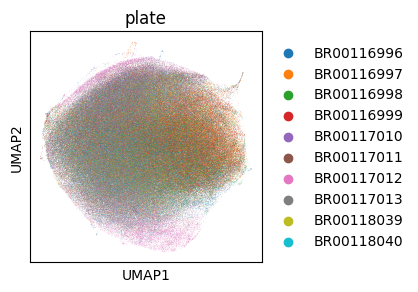

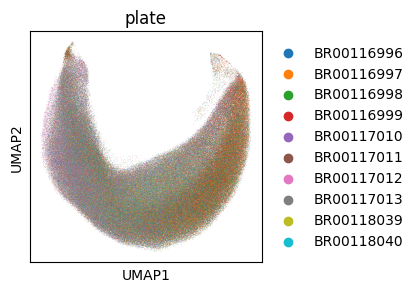

In [129]:
sc.pl.umap(adata_before_correction, color="plate")
sc.pl.umap(adata_after_correction, color="plate")

In [75]:
# data_index.loc[data_index.STATE=="control"]
data_index.CPD_NAME.value_counts()

none                           42149
DMSO                           32853
PDE3A                           1917
HDAC6                           1912
TNF                             1836
                               ...  
puromycin                         17
pyrrolidine-dithiocarbamate        9
LDN-212854                         8
SU3327                             6
AR-12                              4
Name: CPD_NAME, Length: 479, dtype: int64

# CONTROLS

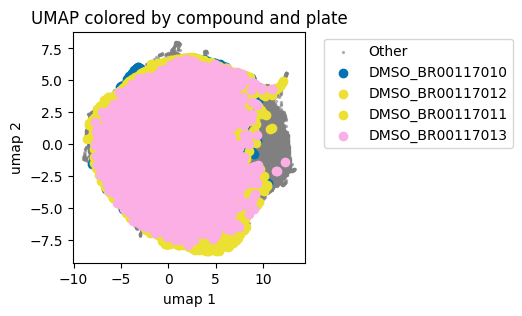

In [133]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "DMSO", dim_red="umap")

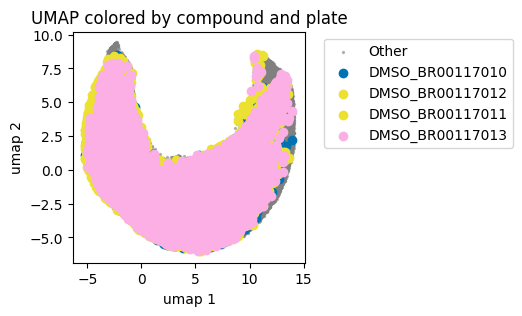

In [132]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "DMSO", dim_red="umap")

# Strong Perturbations

BVT-948

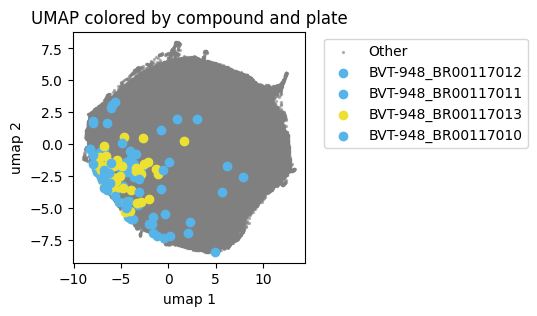

In [134]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "BVT-948", dim_red="umap")

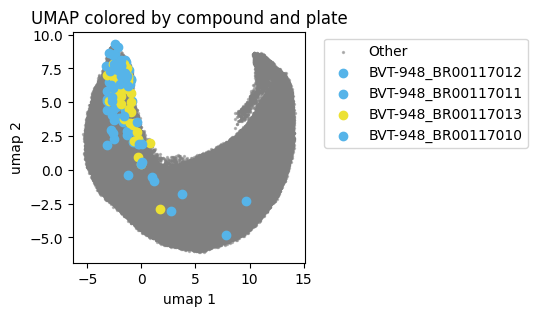

In [135]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "BVT-948", dim_red="umap")

GK921

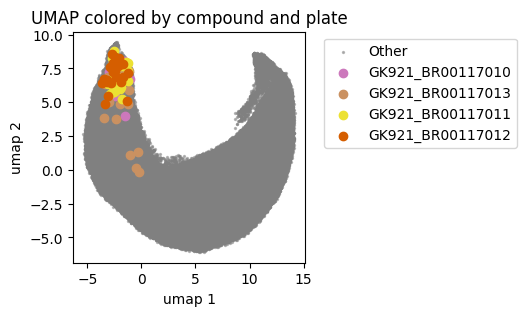

In [136]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "GK921", dim_red="umap")

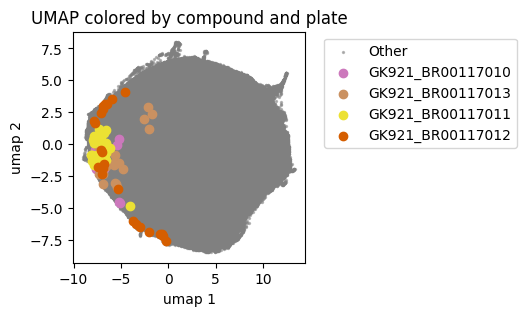

In [137]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "GK921", dim_red="umap")

GSK1070916

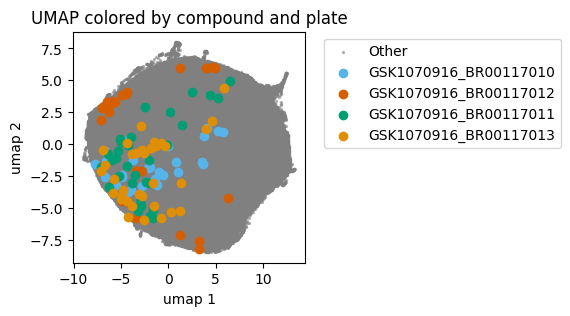

In [138]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "GSK1070916", dim_red="umap")

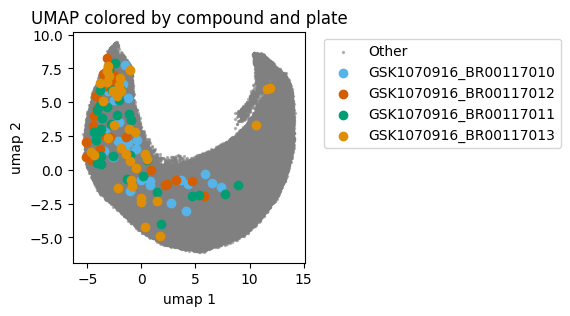

In [139]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "GSK1070916", dim_red="umap")

ITGB2

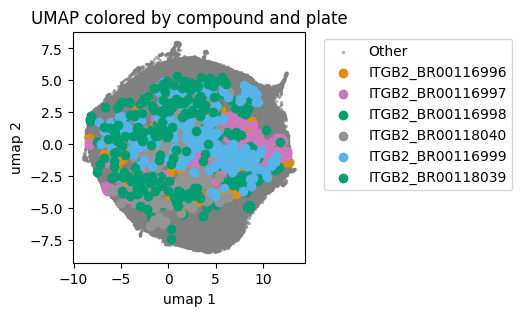

In [140]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "ITGB2", dim_red="umap")

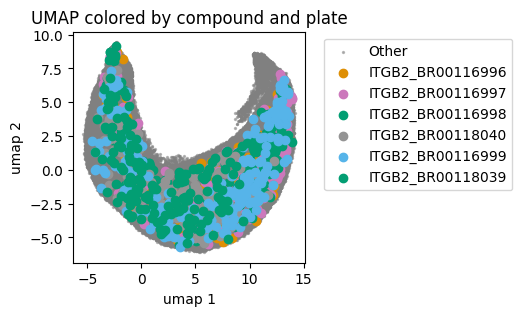

In [141]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "ITGB2", dim_red="umap")

KG-5

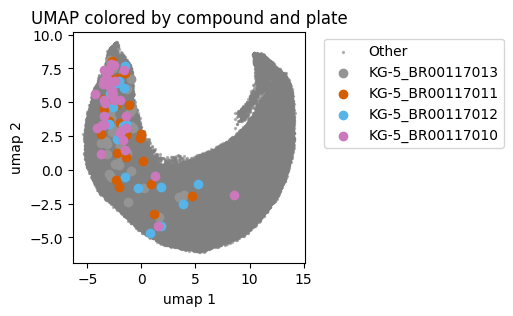

In [142]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "KG-5", dim_red="umap")

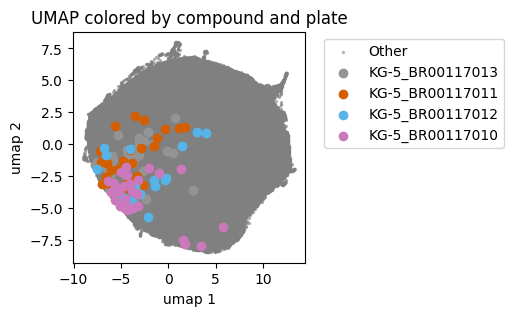

In [143]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "KG-5", dim_red="umap")

NSC-663284

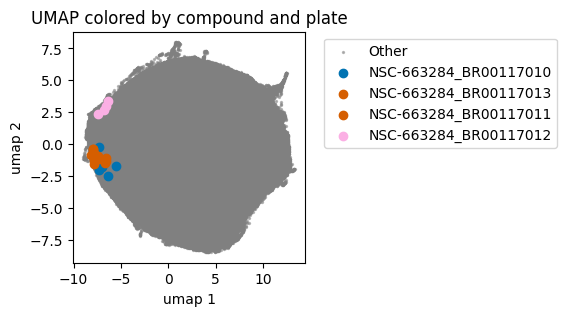

In [144]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "NSC-663284", dim_red="umap")

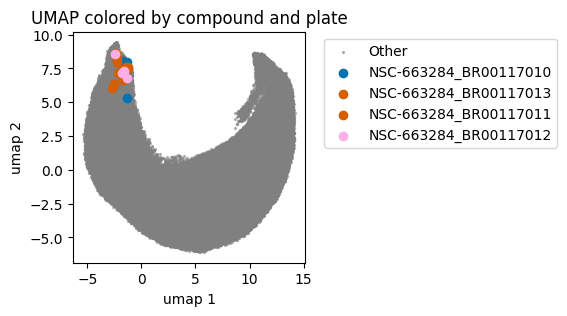

In [145]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "NSC-663284", dim_red="umap")

NXF1

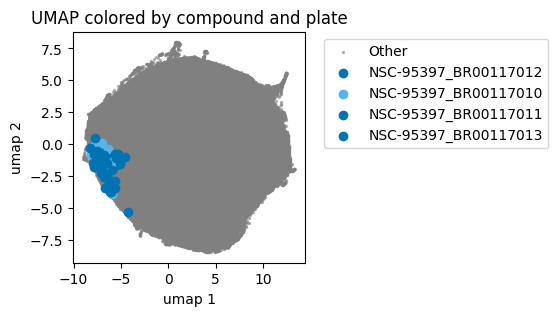

In [146]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "NSC-95397", dim_red="umap")

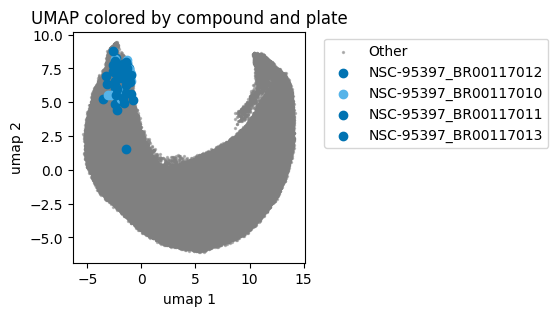

In [147]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "NSC-95397", dim_red="umap")

PP-121

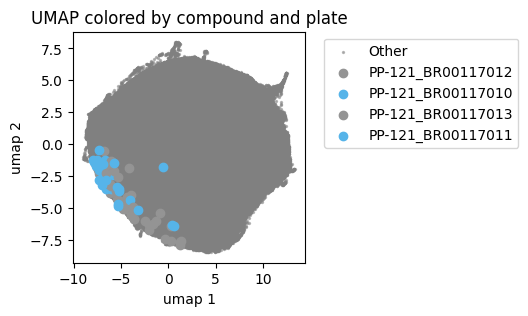

In [148]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "PP-121", dim_red="umap")

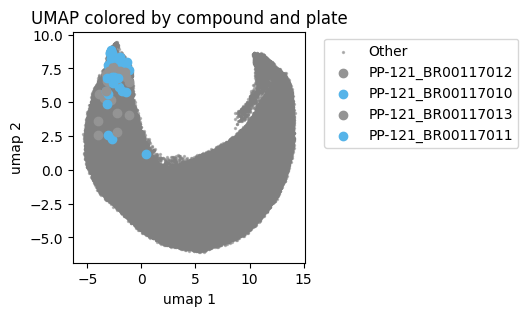

In [149]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "PP-121", dim_red="umap")

TG-101348

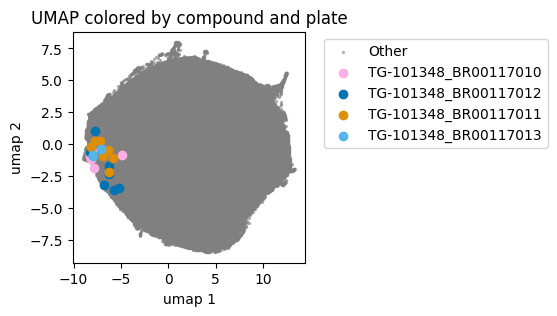

In [150]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "TG-101348", dim_red="umap")

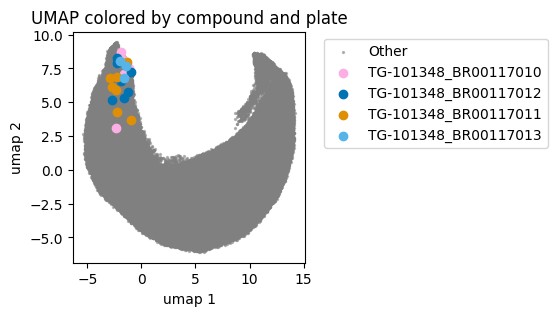

In [151]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "TG-101348", dim_red="umap")

briciclib

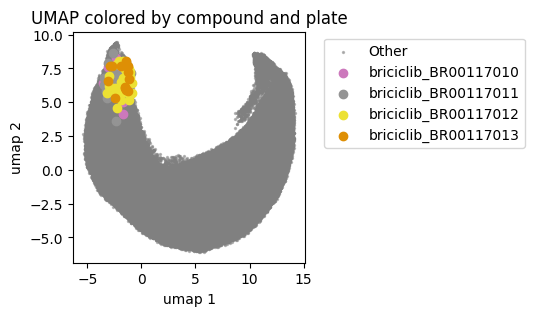

In [152]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "briciclib", dim_red="umap")

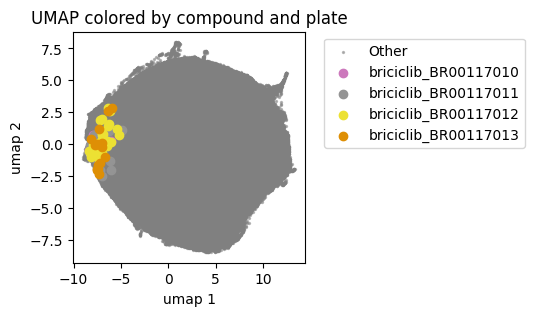

In [153]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "briciclib", dim_red="umap")

colchicine

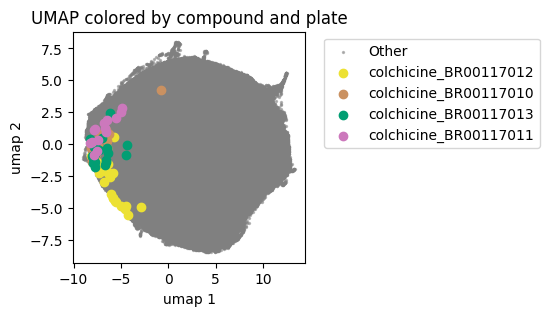

In [154]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "colchicine", dim_red="umap")

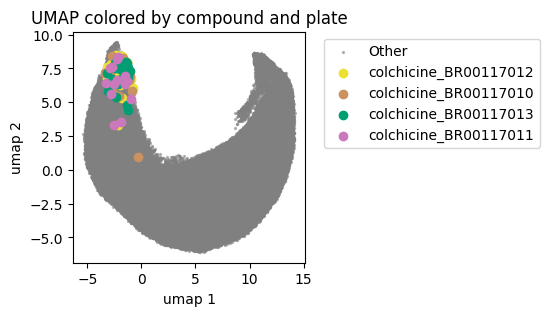

In [155]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "colchicine", dim_red="umap")

homoharringtonine

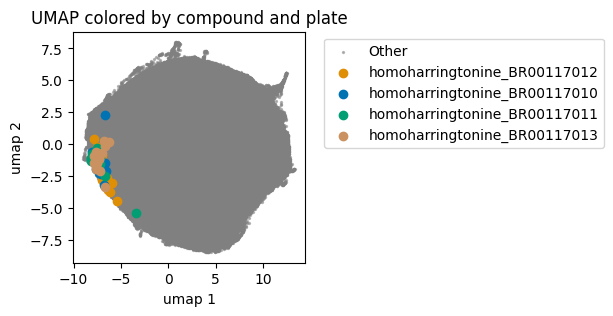

In [156]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "plate", "homoharringtonine", dim_red="umap")

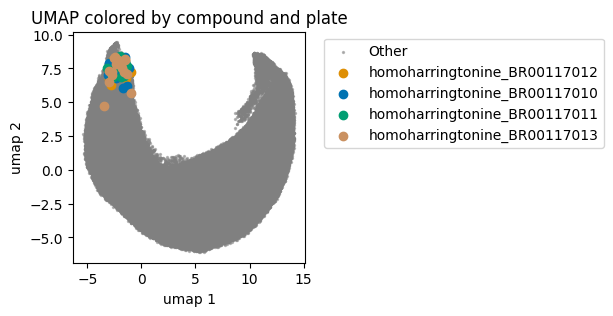

In [157]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "plate", "homoharringtonine", dim_red="umap")

Louvain before and after correction 
- clusters you recover?
- after clustering corresponds to that mode of action
- Show correction data above and bio below 

NIPBL	

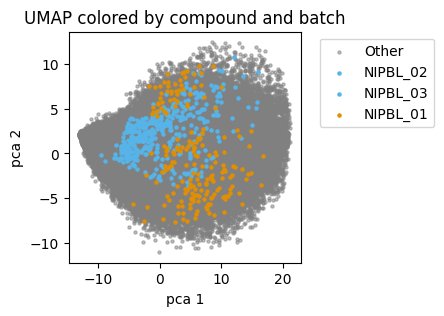

In [26]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "NIPBL", dim_red="pca")

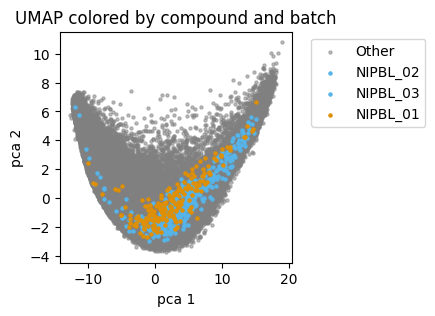

In [27]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "NIPBL", dim_red="pca")

GRN	

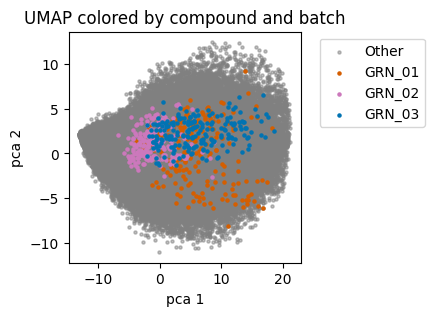

In [28]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "GRN", dim_red="pca")

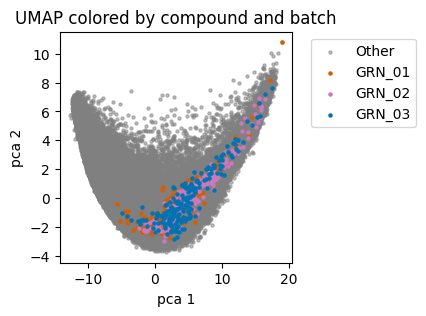

In [29]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "GRN", dim_red="pca")

CYP27A1

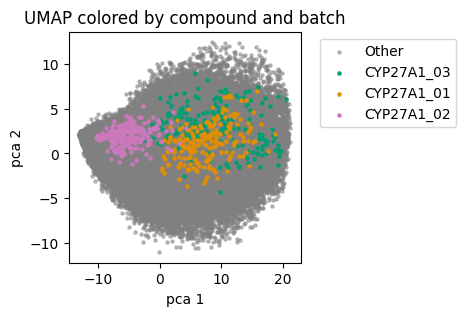

In [30]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "CYP27A1", dim_red="pca")

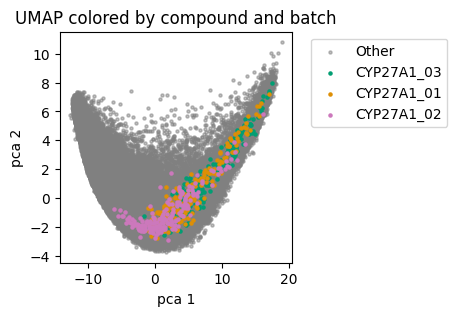

In [31]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "CYP27A1", dim_red="pca")

In [7]:
# adata_scgen = sc.read_h5ad("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/cpg0000/cpg0000_adata_scgen_2.h5ad")
# adata_scpoli = sc.read_h5ad("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/cpg0000/cpg0000_adata_scpoli_2.h5ad")

In [10]:
# sc.pl.umap(adata_scgen, color="plate")

In [11]:
# sc.pl.umap(adata_scpoli, color="plate", s=5)